# Densified Model for Shoal and Waller Creek Watersheds 

Modified from [Dr. Matt Bartos](https://github.com/mdbartos) code ["run_densified_model_with_forcings.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/run_densified_model_with_forcings.ipynb) and ["run_model_collection_with_da.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/run_model_collection_with_da.ipynb) located in [cuahsi-summer-institute-2025](https://github.com/future-water/cuahsi-summer-institute-2025/tree/main) repository. 

Modifications completed by [Victor Oladoja](https://github.com/oladojavictor) and [Megan Vardaman](https://github.com/Megan-Verf) as part of [2025 Water Prediction Innovators Summer Institute Program](https://www.cuahsi.org/summer-institute). 

Team Name: DensiFIMcation 

Members: Victor Oladoja, Alex Simpson, Megan Vardaman

# Import modules

In [70]:
import sys
sys.path.append('../../tx-fast-hydrology')

In [71]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Define region and time period of interest 

Assumes model has already been partitioned into submodel sections (see ["subset_waller_and_shoal_densified.ipynb"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/notebooks/subset_waller_and_shoal_densified.ipynb)) and that NWM output data has already been downloaded and converted to .hdf for the selected dates (see ["nwm_data_loader.py"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/utils/nwm_data_loader.py) and ["rewrite_h5_files.py"](https://github.com/future-water/cuahsi-summer-institute-2025/blob/main/utils/rewrite_h5_files.py)). 

In [72]:
# Define watershed 
ws = 'shoal' # 'waller'
ws_string = 'Shoal Creek' # 'Waller Creek

# Define time period 
startdate = '20220822'
enddate = '20220825'

startdate_string = format(pd.to_datetime(startdate, format = '%Y%m%d'), '%Y-%m-%d')
enddate_string = format(pd.to_datetime(enddate, format = '%Y%m%d'), '%Y-%m-%d')

# Date range to load
date_list = pd.date_range(startdate, enddate, freq='h', tz='utc')[:-1]

# Define path for NWM forcings
forcing_path = '../../cuahsi-summer-institute-2025/data/'+ startdate +'_event'

# Load model collection

In [73]:
# Define model file input path
input_path = '../../cuahsi-summer-institute-2025/data/' + ws + '_densified.json'
# input_path = '../../cuahsi-summer-institute-2025/data/travis-county-hi-res-model.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Shoal')

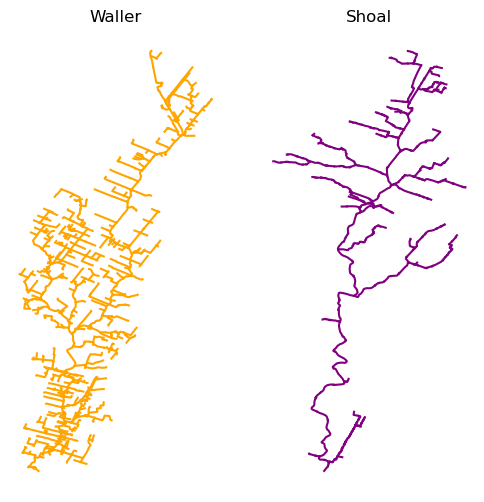

In [74]:
# Plot Shoal and Waller Creek
# Read dumped model files
waller_container = ModelCollection.from_file('../../cuahsi-summer-institute-2025/data/waller_densified.json')
shoal_container = ModelCollection.from_file('../../cuahsi-summer-institute-2025/data/shoal_densified.json')

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(6,6))
for model_name, model in waller_container.models.items():
    model.plot(ax=ax, c='orange')
for model_name, model in shoal_container.models.items():
    model.plot(ax=ax1, c='purple')
ax.axis('off')
ax1.axis('off')
ax.set_title('Waller')
ax1.set_title('Shoal')

# Create model inputs

### Load NWM forcings

In [ ]:
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Optional: Reset Model Timedelta

In [ ]:
# IMPLICATIONS OF THIS PROCESS ON MODEL RESULTS ARE UNCERTAIN 
# for model in model_collection.models.values():
#     # change the timestep
#     model.timedelta = pd.to_timedelta('120s')
#     model.compute_muskingum_coeffs()
#     #print(model.timedelta)

### Create inputs to model based on forcings

In [ ]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
store = pd.HDFStore('../../cuahsi-summer-institute-2025/data/area_fractions.h5', 'r')
hdf_keys = store.keys()
store.close()
for key in hdf_keys:
    comid = key.split('__')[-1]
    area_ratios = pd.read_hdf(f'../../cuahsi-summer-institute-2025/data/area_fractions.h5', key=key)
    for reach_id in area_ratios.index:
        if comid in forcing.columns:
            runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
            reach_id_str = str(reach_id)
            if reach_id_str in inputs.columns:
                inputs[reach_id_str] += runoff_proportion

# NOT NEEDED FOR SHOAL AND WALLER CREEK AREAS -- NO UPSTREAM INPUTS 
# Add inflow to upstream boundary reaches
# upstream_inputs = {
#     '5779305' : '5781161',
#     '5785187' : '5785899',
#     '5786029' : '5785351'
# }
# for downstream_reach, upstream_reach in upstream_inputs.items():
#     inputs[downstream_reach] += streamflow[upstream_reach]

In [10]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
print(dt)
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

10


# Gather gage measurements for event period

### From USGS DataRetrieval Package

In [82]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_densified_reach_df = pd.read_csv('../../cuahsi-summer-institute-2025/data/NWPSGagesTravis_All_Join_to_Densified.csv', index_col=0) 
# print(usgs_to_densified_reach_df.columns)
usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','creek_id']].reset_index(drop=True).dropna().reset_index(drop=True)
usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['creek_id'].astype(int).astype(str)
# Filter 
usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]

# Prepare gage IDs for USGS dataretrieval 
sites = usgs_to_densified_reach_df.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
# sites = usgs_to_comid.usgs_id.dropna().astype(int).astype(str).reset_index(drop = True)
site_ids = []
for i in sites: 
    site_ids.append(i.zfill(8)) # add leading zeros to gage IDs 
# print(site_ids)
print('Number of gages: ' + str(len(site_ids)))

# Get site info 
TCsites = nwis.what_sites(sites = site_ids, startDT=startdate_string, endDT=enddate_string, parameterCd="00060")
print(TCsites[0].head())

# Convert to series 
usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)


Number of gages: 2
  agency_cd   site_no                            station_nm site_tp_cd  \
0      USGS  08156675  Shoal Ck at Silverway Dr, Austin, TX         ST   
1      USGS  08156800     Shoal Ck at W 12th St, Austin, TX         ST   

   dec_lat_va  dec_long_va coord_acy_cd dec_coord_datum_cd  alt_va  \
0   30.354167   -97.738889            S              NAD83  672.72   
1   30.276598   -97.750305            F              NAD83  455.45   

   alt_acy_va alt_datum_cd    huc_cd                    geometry  
0        0.24       NAVD88  12090205  POINT (-97.73889 30.35417)  
1        0.22       NAVD88  12090205   POINT (-97.75031 30.2766)  


20220822
20220825
08156675
08156800


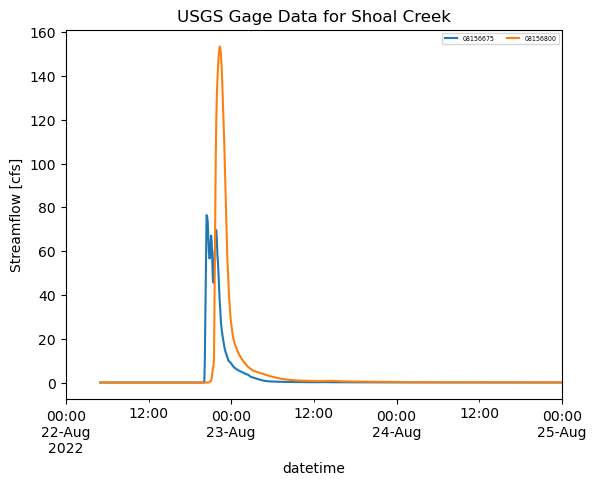

In [83]:
# Restructure data for h5 file 
eventdata = [] 
print(startdate)
print(enddate)

for i in list(set(site_ids)): 
    print(i)
    # fig, ax = plt.subplots()
    df = nwis.get_iv(sites=i, start=startdate_string, end=enddate_string, parameterCd='00060')
    df = pd.DataFrame(df[0])
    if len(df.columns) == 3 and len(df) > 0: 
        df.columns = ['site_no', '00060', 'sensor_cd']
        # print(df.columns)
        # ax.plot(df.index, df['00060']) #df['00060_primary sensor'])
        df1 = pd.DataFrame(df['00060'])
        df1.columns = [i]
        eventdata.append(df1)
    else: 
        # ax.plot(df.index, df.iloc[:,1])
        print(i)
        print(df)
        # df1 = pd.DataFrame(df.iloc[:,1])
    # plt.suptitle(i)
    # plt.show()

# Concatenate event data 
df2 = (pd.concat(eventdata, axis = 1))

# Convert cfs to cms 
df3 = df2*0.02831683199881

# Plot data 
df3.plot()
plt.title('USGS Gage Data for ' + ws_string)
plt.ylabel('Streamflow [cfs]')
plt.legend(ncol = 8, loc = 'upper right', prop = {'size' : 4.5})
plt.xlim(startdate, enddate)

# Export data to hdf 
df3.loc[:, ~df3.columns.duplicated()].to_hdf('../../Project_Data/gages_usgs_'+ startdate +'_to_'+ enddate +'_' + ws + '.h5', key = 'usgs', mode = 'w')

#### Load USGS dataretrieval output

In [ ]:
# Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs') # Original file from Matt Bartos 
measurements = pd.read_hdf('../../Project_Data/gages_usgs_' + startdate + '_to_' + enddate + '_' + ws + '.h5', key = 'usgs') # New file created from dataretrieval 
measurements.columns = measurements.columns.astype(int).astype(str)
# Filter measurements to those with associated COMIDs
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

#### Load original gages file provided by Matt Bartos (optional: alternative to USGS dataretrival method) 

In [ ]:
# # Load table of mappings from USGS Gage IDs to NWM COMIDs
# usgs_to_densified_reach = pd.read_csv('../../cuahsi-summer-institute-2025/data/usgs_reach_id_densified.csv', index_col=0) 
# usgs_to_densified_reach = usgs_to_densified_reach[['usgs_id','reach_id']].reset_index(drop=True).dropna().reset_index(drop=True)
# usgs_to_densified_reach['usgs_id'] = usgs_to_densified_reach['usgs_id'].astype(int).astype(str)
# usgs_to_densified_reach['reach_id'] = usgs_to_densified_reach['reach_id'].astype(int).astype(str)
# # Filter 
# usgs_to_densified_reach = usgs_to_densified_reach[usgs_to_densified_reach['reach_id'].isin(input_columns)]
# usgs_to_densified_reach = pd.Series(usgs_to_densified_reach['reach_id'].values, index=usgs_to_densified_reach['usgs_id'].values)
# # usgs_to_densified_reach.drop(['8154900', '8154500'], inplace=True)


# # Load table of USGS gage measurements
# measurements = pd.read_hdf('../../cuahsi-summer-institute-2025/data/gages.h5', key='usgs')
# measurements.columns = measurements.columns.astype(int).astype(str)
# measurements = measurements[usgs_to_densified_reach.index]
# measurements.columns = measurements.columns.map(usgs_to_densified_reach)
# measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
# measurements = measurements.dropna(axis=1)
# measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
# measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
# measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [46]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and execute simulation with Data Assimilation (DA)

### Prepare model for simulation

In [47]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [48]:
starttime = datetime.datetime.now()
# Simulate models
outputs_da = await simulation.simulate()
endtime = datetime.datetime.now()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)
print(f"the code took {endtime-starttime} to run")

the code took 0:00:12.629830 to run


# Compare results

### Run model with no data assimilation (NODA)

In [ ]:
# Define model file input path
input_path = '../../cuahsi-summer-institute-2025/data/' + ws + '_densified.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

for model in model_collection.models.values():
    # change the timestep
    model.timedelta = pd.to_timedelta('120s')
    model.compute_muskingum_coeffs()
    #print(model.timedelta)

# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

starttime = datetime.datetime.now()

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")

the code took 0:00:00.627316 to run


In [77]:
# Print number of unique IDs (individual reaches) in modeled output 
print(len(outputs_da.columns))

574


### Plot DA result vs. NODA result at gage locations

(0.0, 200.0)

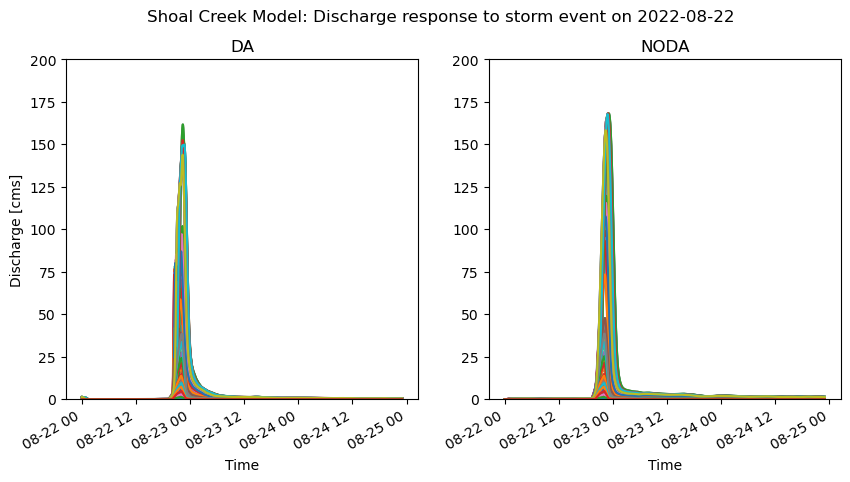

In [ ]:
# Plot model output data 
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharex = True)
outputs_da.plot(ax=ax, legend=False)
outputs_noda.plot(ax=ax1, legend=False)
ax.set_title("DA")
ax1.set_title("NODA")
ax.set_xlabel('Time')
ax1.set_xlabel('Time')
ax.set_ylabel('Discharge [cms]')
fig.suptitle(ws_string + ' Model: Discharge response to storm event on ' + startdate_string)
ax.set_ylim(0,200)
ax1.set_ylim(0,200)
# plt.legend()

### Plot map of gains

In [51]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [52]:
den_streams_tx = gpd.read_file('../../cuahsi-summer-institute-2025/data/travis_densified_streamlines')
den_streams_tx['reach_id'] = den_streams_tx['reach_id'].astype(int).astype(str)
den_streams_travis = den_streams_tx[den_streams_tx['reach_id'].isin(input_columns)].copy()
den_streams_travis['gain'] = den_streams_travis['reach_id'].map(total_gain).fillna(0.).values
den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

In [79]:
num_sec = str(int(model_collection.timedelta.total_seconds()))
print((num_sec))

10


In [ ]:
# Compare maximum modeled streamflow value across all reaches for DA and NODA runs 
print('No DA: ' + str(round(outputs_noda.max().max(), 3)))
print('DA: ' + str(round(outputs_da.max().max(), 3)))

No DA: 168.219
DA: 147.944


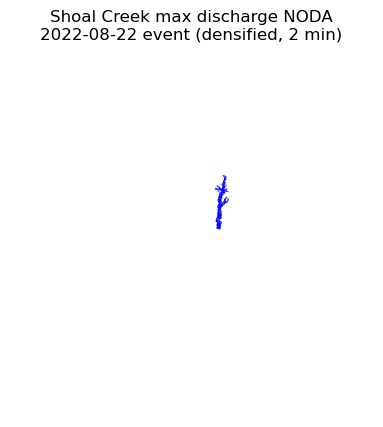

In [ ]:
# take output from current time step and plot on the densified national water model stream network
fig, ax = plt.subplots()
den_streams_tx['flow'] = den_streams_tx['reach_id'].map(outputs_noda.max(axis=0)).fillna(0.).values
den_streams_tx.plot(ax=ax, color='b', zorder=3, 
                        linewidth=0.5*np.log(1 + den_streams_tx['flow'].values))
plt.title(ws_string + " max discharge NODA\n" + startdate_string + " event (densified, " + num_sec + " min)")
_ = plt.axis('off')
# plt.savefig('../figures/MaxDischarge_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

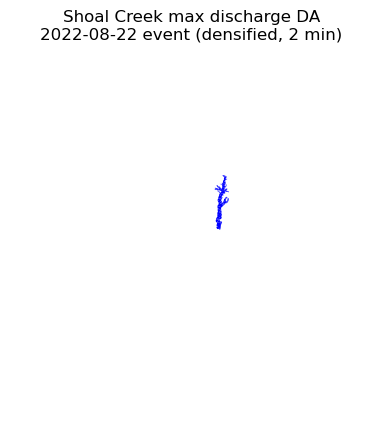

In [ ]:
# take output from current time step and plot on the densified national water model stream network
fig, ax = plt.subplots()
den_streams_tx['flow'] = den_streams_tx['reach_id'].map(outputs_da.max(axis=0)).fillna(0.).values
den_streams_tx.plot(ax=ax, color='b', zorder=3, 
                        linewidth=0.5*np.log(1 + den_streams_tx['flow'].values))
plt.title(ws_string + " max discharge DA\n" + startdate_string + " event (densified, " + num_sec + " min)")
_ = plt.axis('off')
# plt.savefig('../figures/MaxDischarge_DA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

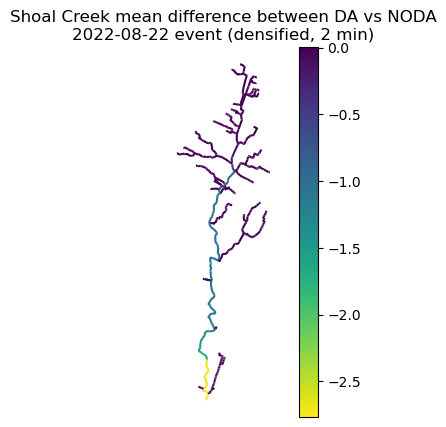

In [ ]:
den_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title(ws_string + " mean difference between DA vs NODA\n" + startdate_string + " event (densified, " + num_sec + " min)")
_ = plt.axis('off')
# plt.savefig('../figures/MeanDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

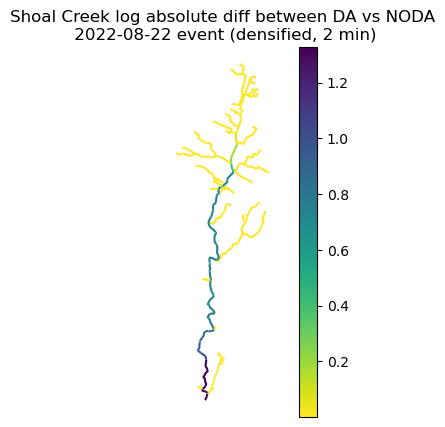

In [ ]:
den_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title(ws_string + " log absolute diff between DA vs NODA\n " + startdate_string + " event (densified, " + num_sec + " min)")
_ = plt.axis('off')
# plt.savefig('../figures/LogAbsoluteDifferenceDA_NODA_Den_' + num_sec + 'sec_' + startdate + '_' + ws + '.png', dpi=600)

# Export peak flow data to csv 

In [ ]:
# Organize and export model ouput data 
outputs = pd.concat([pd.DataFrame(outputs_da.max(), columns = ['q_cfs_da']), pd.DataFrame(outputs_noda.max(), columns = ['q_cfs_no_da'])], axis = 1)
outputs.index = outputs.index.astype(int)
outputs.index.name = 'ID'
print(outputs.index.name)
outputs = outputs * 35.314684921034 # convert back to cfs for ESRI geoprocessing 
# Save csv 
outputs.to_csv('../../Project_Data/densified_model_collection_' + num_sec + 'sec_' + startdate + '_' + ws + '.csv')

ID


In [ ]:
# Read csv output 
outputs = pd.read_csv('../../Project_Data/densified_model_collection_' + num_sec + 'sec_' + startdate + '_' + ws + '.csv')
print(outputs)

          ID     q_cfs_da  q_cfs_no_da
0    2329714     5.098818     5.098818
1    2329107    12.133654    12.133654
2    2329715    13.854351    13.854353
3    2351624   125.533681   125.533681
4    2330489  4416.671133  5571.537459
..       ...          ...          ...
569  2361778   337.489262   337.574652
570  2345886    11.301095    11.301095
571  2348756   264.879192   264.883897
572  2368012    51.922783    51.922783
573  2351642   177.212304   177.212304

[574 rows x 3 columns]
